In [1]:
# !pip install -q scikit-surprise flask-ngrok pyngrok
# # !pip install -q implicit
# !pip install -q fastparquet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, json, random, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok

In [3]:
!ls


Music.csv  sample_data


In [4]:
# from google.colab import files
# # uploaded = files.upload()
# fname = list(uploaded.keys())[0]
df = pd.read_csv('/content/Music.csv')


# print("✅ Uploaded:", fname)
print("Shape:", df.shape)
df.head()


Shape: (65795, 20)


,name,artist,spotify_id,preview,img,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,acousticness_artist,danceability_artist,energy_artist,instrumentalness_artist,liveness_artist,speechiness_artist,valence_artist
0,Mood (feat. iann dior),24kGoldn,3tjFYV6RSFtuktYl3ZtYcq,https://p.scdn.co/mp3-preview/45cb08fdb67744ab...,https://i.scdn.co/image/ab67616d0000b273ff8c98...,0.700,0.722,-3.558,0.0369,0.22100,0.000000,0.2720,0.756,0.118269,0.731588,0.681235,0.000002,0.160000,0.123765,0.566824
1,Blinding Lights,The Weeknd,0VjIjW4GlUZAMYd2vXMi3b,NaN,https://i.scdn.co/image/ab67616d0000b2738863bc...,0.514,0.730,-5.934,0.0598,0.00146,0.000095,0.0897,0.334,0.271439,0.574808,0.607873,0.010594,0.201728,0.086811,0.305189
2,Dynamite,BTS,0t1kP63rueHleOhQkYSXFY,https://p.scdn.co/mp3-preview/a707728846c105f4...,https://i.scdn.co/image/ab67616d0000b273755995...,0.746,0.765,-4.410,0.0993,0.01120,0.000000,0.0936,0.737,0.099350,0.614798,0.786452,0.000044,0.202608,0.128515,0.533369
3,ROCKSTAR (feat. Roddy Ricch),DaBaby,7ytR5pFWmSjzHJIeQkgog4,NaN,https://i.scdn.co/image/ab67616d0000b27320e08c...,0.746,0.690,-7.956,0.1640,0.24700,0.000000,0.1010,0.497,0.093113,0.829283,0.657626,0.000002,0.170425,0.284725,0.629374
4,For The Night (feat. Lil Baby & DaBaby),Pop Smoke,0PvFJmanyNQMseIFrU708S,NaN,https://i.scdn.co/image/ab67616d0000b27377ada0...,0.823,0.586,-6.606,0.2000,0.11400,0.000000,0.1930,0.347,0.191520,0.675143,0.702686,0.000194,0.247669,0.280103,0.490229


Data PreProcessing

In [34]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 🎵 Add artist encoding to make songs by different artists more distinct
df['artist_encoded'] = pd.factorize(df['artist'])[0]

# Select and scale richer feature set
feature_cols = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'artist_encoded'
]

available = [c for c in feature_cols if c in df.columns]

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[available])

print("✅ Scaled features:", len(available))
print("✅ Scaled shape:", scaled.shape)



✅ Scaled features: 9
✅ Scaled shape: (4000, 9)


Exploratory Data Analysis (EDA)

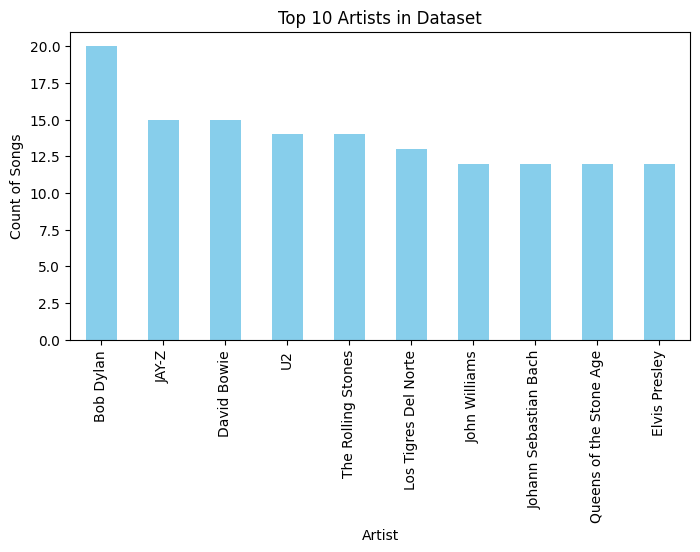

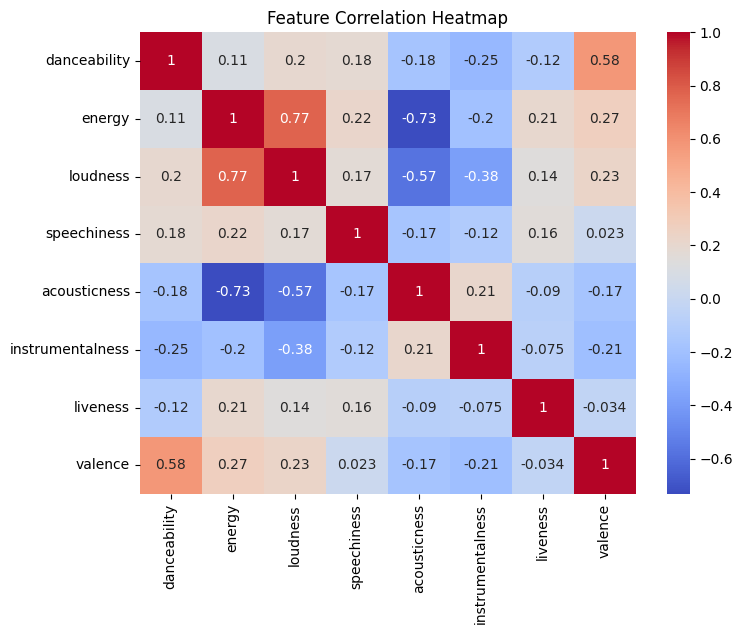

In [35]:
# Top artists by count
plt.figure(figsize=(8,4))
df['artist'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Artists in Dataset")
plt.xlabel("Artist")
plt.ylabel("Count of Songs")
plt.show()

# Feature correlation heatmap
feature_cols = ['danceability','energy','loudness','speechiness',
                'acousticness','instrumentalness','liveness','valence']

plt.figure(figsize=(8,6))
sns.heatmap(df[feature_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


Content-Based Filtering (TF-IDF + Cosine Similarity)

In [36]:


# Compute cosine similarity

def recommend_content(song, top_k=5):
    song = song.lower()
    if song not in df['title'].str.lower().values:
        return {"error": "Song not found"}
    idx = df[df['title'].str.lower() == song].index[0]

    # compute similarity for only this song
    song_vec = scaled[idx].reshape(1, -1)
    sims = cosine_similarity(song_vec, scaled).flatten()

    # sort & select top_k
    scores = list(enumerate(sims))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_k+1]

    # Ensure indices are valid before accessing df
    valid_indices = [i[0] for i in scores if i[0] < len(df)]
    recs = df.iloc[valid_indices][['title','artist']].to_dict(orient='records')
    return {"source":"content","input":song,"recommendations":recs}

Collaborative Filtering (Matrix Factorization using TruncatedSVD)

In [50]:
from sklearn.decomposition import TruncatedSVD
import random # Import the random module

# If your dataset doesn't have users/ratings, create synthetic ones for demo
if 'user_id' not in df.columns:
    df['user_id'] = [f"user_{i%100}" for i in range(len(df))]  # 100 fake users
if 'rating' not in df.columns:
    df['rating'] = np.random.randint(1,6,len(df))  # random ratings 1–5

# Create user-song matrix
user_song_matrix = df.pivot_table(index='user_id', columns='title', values='rating').fillna(0)

# Train SVD
svd = TruncatedSVD(n_components=15, random_state=42)
matrix = svd.fit_transform(user_song_matrix)

# Get the list of song titles that the SVD was trained on
svd_song_titles = user_song_matrix.columns


# Define recommend_cf() to recommend for a random user
def recommend_cf(song=None, top_k=5): # Make song input optional
    # Select a random user
    random_user_id = random.choice(user_song_matrix.index)
    user_ratings = user_song_matrix.loc[random_user_id]

    # Get songs the user has rated highly (e.g., rating >= 4)
    high_rated_songs = user_ratings[user_ratings >= 4].index.tolist()

    if not high_rated_songs:
        return {"source": "cf", "input": f"random_user:{random_user_id}", "recommendations": []}

    # Ensure all high_rated_songs are in the list of songs the SVD was trained on
    high_rated_songs = [s for s in high_rated_songs if s in svd_song_titles]

    if not high_rated_songs:
         return {"source": "cf", "input": f"random_user:{random_user_id}", "recommendations": []}

    # Use the SVD matrix for similarity
    # Get the indices of the high rated songs in the SVD trained columns
    high_rated_indices = [svd_song_titles.get_loc(s) for s in high_rated_songs]

    # Use the user's row from the SVD matrix as the profile
    user_profile_vector = matrix[user_song_matrix.index.get_loc(random_user_id), :].reshape(1,-1)

    # Calculate similarity between the user's profile vector and all song vectors in the SVD matrix
    sims = cosine_similarity(user_profile_vector, matrix).flatten()


    # Get top similar songs, excluding songs the user has already rated
    # Get indices of songs the user has rated (any rating) that are in the SVD trained columns
    rated_song_indices = [svd_song_titles.get_loc(s) for s in user_ratings[user_ratings > 0].index.tolist() if s in svd_song_titles]


    # Sort by similarity and exclude rated songs
    sorted_indices = sims.argsort()[::-1]
    recommended_indices = [idx for idx in sorted_indices if idx not in rated_song_indices][:top_k]


    recs = []
    for idx in recommended_indices:
         # Ensure index is valid before accessing svd_song_titles
        if 0 <= idx < len(svd_song_titles):
            recs.append({'title': svd_song_titles[idx], 'similarity': round(float(sims[idx]), 3)})
        else:
            pass # print(f"Warning: Index {idx} out of bounds for svd_song_titles.")


    return {"source": "cf", "input": f"random_user:{random_user_id}", "recommendations": recs}


# ✅ Test collaborative filtering with random user
print(recommend_cf())

{'source': 'cf', 'input': 'random_user:user_43', 'recommendations': [{'title': '3 Legs - Remastered 2012', 'similarity': 1.0}, {'title': '"40" - Live', 'similarity': 0.669}, {'title': '(How Much Is That) Doggie In The Window', 'similarity': 0.655}, {'title': 'A Bit of Finger / Sleeping Village / Warning - 2013 Remaster', 'similarity': 0.578}, {'title': '(BALLAD OF) THE HIP DEATH GODDESS', 'similarity': 0.481}]}


In [11]:
# # Show random 5 songs with their Spotify preview links
# df[['title','artist','preview','spotify_id']].sample(5)


,title,artist,preview,spotify_id
140,Who Gives A F**K Where You From (feat. Three 6...,DJ Kay Slay,no,0xbGaV9RsogLDkCuiRdnrI
2743,"The Rain, The Park & Other Things - Single Ver...",The Cowsills,no,0sOoGrE5PY5EBDQnR7Yysu
2895,Tarjeta Roja,Paco Barrón y sus Norteños Clan,no,64JfGpwRR1WOmlZnzrn0uE
509,El Disgusto - Live Version,Eddie Gonzalez,no,5AeWBUrE7lciBJP3YlzzIw
2968,The Rain Song - Live at MSG 1973; 2018 Remaster,Led Zeppelin,no,0VG9YWiGjyoKZNLurIhDfW


In [39]:
# --- Diagnostic checks ---
print("Rows in df:", len(df))
print("Index max:", df.index.max())
print("Unique titles:", df['title'].nunique())

# any NaN or empty titles?
print("Missing titles:", df['title'].isna().sum())

# see if the song you are testing exists in lowercase
example = df['title'].iloc[0]
print("Example song:", example)
print("Found indices for that song:", df.index[df['title'].str.lower() == example.lower()].tolist())


Rows in df: 4000
Index max: 3999
Unique titles: 3969
Missing titles: 0
Example song: Pretending
Found indices for that song: [0]


Hybrid Model (Combining Content + Collaborative)

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import random # Import the random module

def recommend_hybrid(song, alpha=0.4, top_k=5): # Reduced alpha to give more weight to CF
    song = song.strip().lower()

    # Check if base song exists
    matches = df[df['title'].str.lower() == song]
    if matches.empty:
        return {"error": f"Song '{song}' not found in dataset."}

    base_idx = matches.index[0]
    base_song = df['title'].iloc[base_idx]

    # Re-scale features within the function to ensure index alignment
    feature_cols = ['danceability','energy','loudness','speechiness',
                    'acousticness','instrumentalness','liveness','valence']
    available = [c for c in feature_cols if c in df.columns]

    scaler = MinMaxScaler()
    scaled_internal = scaler.fit_transform(df[available])
    base_vec = scaled_internal[base_idx].reshape(1, -1)

    # Get content-based + CF recs
    c1 = recommend_content(song, top_k*3) # Fetch more candidates to allow for random selection
    c2 = recommend_cf(base_song, top_k*3) # Use base_song for CF, fetch more candidates

    # Check for errors in individual recommendation functions
    if 'error' in c1:
        return {"error": f"Content-based recommendation failed: {c1['error']}"}

    cf_failed_song_not_found = False
    if 'error' in c2 and c2['error'] == "Song not found":
        cf_failed_song_not_found = True
    elif 'error' in c2:
         return {"error": f"Collaborative filtering recommendation failed: {c2['error']}"}


    if 'recommendations' not in c1 or ('recommendations' not in c2 and not cf_failed_song_not_found):
        return {"error": "Unable to generate hybrid recommendations. Unexpected output format from sub-recommenders."}


    combined_titles = list(set([r['title'] for r in c1['recommendations']] +
                               ([r['title'] for r in c2['recommendations']] if not cf_failed_song_not_found else [])))

    ranked = []

    for t in combined_titles:
        if t.lower() == song:  # Skip self
            continue

        # Ensure song exists before indexing
        t_match = df[df['title'] == t]
        if t_match.empty:
            # Uncomment below line to see what was skipped
            # print(f"⚠️ Skipped missing title: {t}")
            continue

        t_idx = t_match.index[0]

        # --- Content Similarity ---
        s1 = 0
        try:
            # Ensure t_idx is a valid index for scaled_internal
            if 0 <= t_idx < len(scaled_internal):
                s1 = cosine_similarity(base_vec, scaled_internal[t_idx].reshape(1, -1))[0][0]
            else:
                s1 = 0 # Set similarity to 0 if index is out of bounds
        except Exception:
            s1 = 0


        # --- Collaborative Similarity ---
        s2 = 0
        if not cf_failed_song_not_found and (base_song in user_song_matrix.columns) and (t in user_song_matrix.columns):
            try:
                s_vec = user_song_matrix[base_song].values.reshape(1, -1)
                t_vec = user_song_matrix[t].values.reshape(1, -1)
                s2 = cosine_similarity(s_vec, t_vec)[0][0]
            except Exception:
                s2 = 0

        # Calculate score based on whether CF failed or not
        if cf_failed_song_not_found:
            score = s1  # Use only content similarity
        else:
            score = alpha * s1 + (1 - alpha) * s2 # Use hybrid score


        ranked.append((t, score))

    if not ranked:
        return {"error": f"No valid similar songs found for '{song}'."}

    # Sort and then randomly select from the top candidates
    ranked = sorted(ranked, key=lambda x: x[1], reverse=True)

    # Take top_k * 2 candidates for potential random selection
    top_candidates = ranked[:top_k*2]

    # Randomly sample top_k from the top candidates
    if len(top_candidates) > top_k:
        final_recommendations = random.sample(top_candidates, top_k)
    else:
        final_recommendations = top_candidates


    # Return formatted output
    recs = [{"title": r[0], "similarity": round(r[1], 3)} for r in final_recommendations]
    return {"source": "hybrid", "input": song, "recommendations": recs}


# Test the hybrid recommender safely
example = df['title'].iloc[0]
print(recommend_hybrid(example))

{'source': 'hybrid', 'input': 'pretending', 'recommendations': [{'title': 'Needs', 'similarity': np.float64(0.967)}, {'title': 'Amándote', 'similarity': np.float64(0.98)}, {'title': "You Won't See Me Tonight (feat. Aaliyah)", 'similarity': np.float64(0.958)}, {'title': 'Green Peppers', 'similarity': np.float64(0.957)}, {'title': 'Mother Of Pearl', 'similarity': np.float64(0.994)}]}


In [52]:
example = df['title'].iloc[0]
print("🤝 CF Test:", recommend_cf(example))
print("💫 Hybrid Test:", recommend_hybrid(example))


🤝 CF Test: {'source': 'cf', 'input': 'random_user:user_72', 'recommendations': [{'title': 'A Girl in Trouble (Is a Temporary Thing)', 'similarity': 1.0}, {'title': '25 or 6 to 4', 'similarity': 0.747}, {'title': 'A Boy Named Sue - Live', 'similarity': 0.564}, {'title': "A Love That's True, Part 1", 'similarity': 0.531}, {'title': '43% Burnt', 'similarity': 0.442}]}
💫 Hybrid Test: {'source': 'hybrid', 'input': 'pretending', 'recommendations': [{'title': 'The Horizontal Bop', 'similarity': np.float64(0.398)}, {'title': 'Party Fears Two', 'similarity': np.float64(0.398)}, {'title': 'Ricochet - 2018 Remaster', 'similarity': np.float64(0.399)}, {'title': 'Flaming Youth', 'similarity': np.float64(0.4)}, {'title': 'Son of the South', 'similarity': np.float64(0.398)}]}


Model Evaluation (RMSE & Similarity Heatmap)

In [63]:
reconstructed = svd.inverse_transform(matrix)
rmse = sqrt(mean_squared_error(user_song_matrix.values, reconstructed))
print(f"Model RMSE: {rmse:.4f}")


Model RMSE: 0.3860


In [66]:
# app = Flask(__name__)
# HTML_PAGE = """
# <!DOCTYPE html><html><body>
# <h2>🎶 Music Recommender</h2>
# <input id='song' placeholder='Enter a song name'><button onclick='rec()'>Recommend</button>
# <ul id='res'></ul>
# <script>
# async function rec(){
#  let s = document.getElementById('song').value;
#  let res = await fetch('/recommend', {method:'POST',headers:{'Content-Type':'application/json'},body:JSON.stringify({song:s})});
#  let data = await res.json();
#  document.getElementById('res').innerHTML = data.recommendations.map(x=>'<li>'+x+'</li>').join('');
# }
# </script></body></html>
# """

# @app.route('/')
# def index(): return HTML_PAGE

# @app.route('/recommend', methods=['POST'])
# def api_recommend():
#     song = request.json.get('song','')
#     result = recommend_hybrid(song)
#     return jsonify(result)

# port = 5000
# public_url = ngrok.connect(port).public_url
# print("🌍 ngrok public URL:", public_url)
# app.run(port=port)


In [58]:
print(recommend_content(example))
print(recommend_cf(example))
print(recommend_hybrid(example))


{'source': 'content', 'input': 'pretending', 'recommendations': [{'title': 'Flaming Youth', 'artist': 'KISS'}, {'title': 'No Way', 'artist': 'Pearl Jam'}, {'title': "I Cannot Believe It's True - 2016 Remaster", 'artist': 'Phil Collins'}, {'title': 'Ricochet - 2018 Remaster', 'artist': 'David Bowie'}, {'title': 'Center Of My World', 'artist': 'Chris Young'}]}
{'source': 'cf', 'input': 'random_user:user_78', 'recommendations': [{'title': 'A Little Too Late', 'similarity': 1.0}, {'title': '16 Toneladas', 'similarity': 0.54}, {'title': '1-Luv (feat. Leviti)', 'similarity': 0.523}, {'title': 'A Higher Place', 'similarity': 0.486}, {'title': '(Theme From) Midnight Express', 'similarity': 0.459}]}
{'source': 'hybrid', 'input': 'pretending', 'recommendations': [{'title': 'Flaming Youth', 'similarity': np.float64(0.4)}, {'title': 'Party Fears Two', 'similarity': np.float64(0.398)}, {'title': 'No Way', 'similarity': np.float64(0.399)}, {'title': 'Center Of My World', 'similarity': np.float64(0.3

In [59]:
from collections import defaultdict
import numpy as np

def precision_recall_at_k(k=5):
    precisions = []
    recalls = []

    # Pick 20 random users to evaluate
    sample_users = np.random.choice(df['user_id'].unique(), size=20, replace=False)

    for user in sample_users:
        # Songs that the user actually liked (rating >= 4)
        true_items = set(df[(df['user_id'] == user) & (df['rating'] >= 4)]['title'])
        if not true_items:
            continue

        # Pick one of the songs they liked
        base_song = list(true_items)[0]

        recs = recommend_hybrid(base_song, top_k=k)
        if 'recommendations' not in recs:
            continue

        predicted_items = set([r['title'] for r in recs['recommendations']])

        # Count true positives
        tp = len(true_items & predicted_items)
        precision = tp / k
        recall = tp / len(true_items)
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)


# 🎯 Run the evaluation
p, r = precision_recall_at_k(k=5)
print(f"Precision@5: {p:.3f}")
print(f"Recall@5: {r:.3f}")


Precision@5: 0.030
Recall@5: 0.004


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


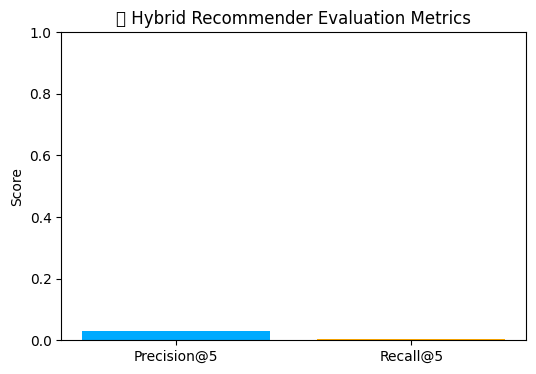

In [60]:
import matplotlib.pyplot as plt

metrics = ['Precision@5', 'Recall@5']
values = [p, r]

plt.figure(figsize=(6,4))
plt.bar(metrics, values, color=['#00aaff','#ffaa00'])
plt.ylim(0, 1)
plt.title("🎵 Hybrid Recommender Evaluation Metrics")
plt.ylabel("Score")
plt.show()


In [65]:
import pickle
pickle.dump({
    "df": df,
    "scaler": scaler,
    "svd": svd,
    "scaled": scaled,
    "user_song_matrix": user_song_matrix
}, open("music_model.pkl", "wb"))


In [67]:
from google.colab import files
files.download("music_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>